<a href="https://colab.research.google.com/github/freison/DeepLearning/blob/master/Laboratory_2_Computer_Vision_Part_2_Debiasing_Facial_Detection_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Debiasing Facial Detection Systems

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('59bMh59JQDo')

In [5]:
import tensorflow as tf
tf.enable_eager_execution()

import functools
import matplotlib.pyplot as plt
import numpy as np
import pdb

# Download the class repository
! git clone https://github.com/aamini/introtodeeplearning_labs.git  > /dev/null 2>&1
% cd introtodeeplearning_labs 
! git pull
% cd .. 

# Import the necessary class-specific utility files for this lab
import introtodeeplearning_labs as util

/content/introtodeeplearning_labs
Already up to date.
/content


In [6]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/l5iqduhe0gwxumq/train_face.h5?dl=1')

1263902720/1263889489 [==============================] - 24s 0us/step


In [7]:
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = util.TrainingDatasetLoader(path_to_training_data)

Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [0]:
# We can look at the size of the training dataset and grab a batch of size 100:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

In [0]:
face_images= images[np.where(labels ==1)[0]]
not_face_images = images[np.where(labels == 0)[0]]

idx_face = 5 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 11 #@param{type: "slider", min:0, max:50, step:1}

plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.imshow(face_images[idx_face])
plt.title("Face")
plt.grid(False)

plt.subplot(1,2,2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face")
plt.grid(False)

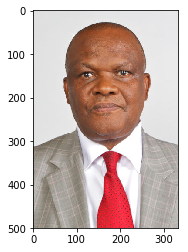

In [23]:
#@title {run:"auto"}

ppb = util.PPBFaceEvaluator() # create the dataset handler

gender = "male" #@param ["male", "female"]
skin_color = "darker" #@param ["lighter", "darker"]

img = ppb.get_sample_faces_from_demographic(gender, skin_color)
plt.imshow(img)
plt.grid(False)

In [26]:
n_outputs = 1 # number of outputs (i.e., face or not face)
n_filters = 12 # base number of convolutional filters

'''Function to define a standar CNN model'''
def make_standard_classifier():
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding ="same", activation ="relu")
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation = "relu")
  
  model = tf.keras.Sequential([
      Conv2D(filters = 1*n_filters, kernel_size = [5,5], strides = [2,2], input_shape=(64,64,3)),
      BatchNormalization(),
      
      Conv2D(filters = 2*n_filters, kernel_size = [5,5], strides = [2,2]),
      BatchNormalization(),
      
      Conv2D(filters = 4*n_filters, kernel_size = [3,3], strides = [2,2]),
      BatchNormalization(),
      
      Conv2D(filters = 6*n_filters, kernel_size = [3,3], strides = [1,1]),
      BatchNormalization(),
      
      Flatten(),
      Dense(1, activation = None),
      tf.keras.layers.Dropout(0.5)
  ])
  return model

standar_classifier = make_standard_classifier()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


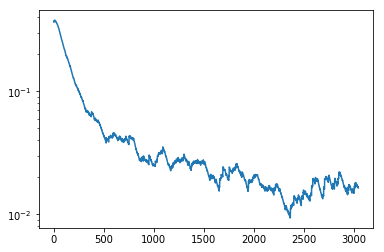

100%|######################################|Time:  0:00:52  Epoch: 9 Loss: 0.01


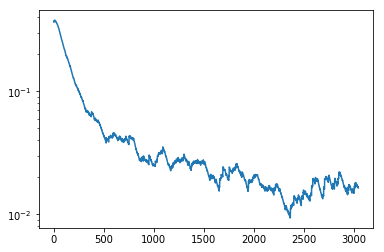

In [32]:
batch_size = 36
num_epochs = 10 # Keep small to run faster
learning_rate = 1e-3

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate) # define our optimizer
loss_history = util.LossHistory(smoothing_factor = 0.99)
plotter =util.PeriodicPlotter(sec = 2,scale = "semilogy")

# The training loop!
for epoch in range(num_epochs):
  
  custom_msg = util.custom_progress_text("Epoch: %(epoch).0f Loss: %(loss)2.2f")
  bar = util.create_progress_bar(custom_msg)
  
  for idx in bar(range(loader.get_train_steps_per_epoch(batch_size))):
    # First grab a batch of training data and convert the input images to tensor
    x, y = loader.get_batch(batch_size)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
    
    # GradientTape to record differentiation operations
    with tf.GradientTape() as tape:
      logits = standar_classifier(x) # Feed the images into the model
      loss_value = tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = logits) # compute the loss
      
    custom_msg.update_mapping(epoch = epoch, loss = loss_value.numpy().mean())
    # Backpropagation
    grads =tape.gradient(loss_value, standar_classifier.variables)
    optimizer.apply_gradients(zip(grads, standar_classifier.variables), global_step = tf.train.get_or_create_global_step())
    
    loss_history.append(loss_value.numpy().mean())
    plotter.plot(loss_history.get())
    

In [33]:
# Evaluate performance of the standard CNN
  #Evaluate ona subset of CelebA+Imagenet
(batch_x, batch_y) =loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standar_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
print("Standard CNN accuracy on (potentially biased) training set: {:-4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) training set: 0.996800


In [37]:
# Evaluate on PPB dataset (takes ~3 minutes)
standard_cnn_accuracy = []
for skin_color in ['lighter','darker']:
  for gender in ['male', 'female']:
    standard_cnn_accuracy.append(ppb.evaluate([standar_classifier], gender, skin_color, from_logit =True)
                                 [0])
    print()
    print("{} {}: {}".format(gender, skin_color, standard_cnn_accuracy[-1]))

100% (97 of 97) |########################| Elapsed Time: 0:01:28 Time:  0:01:28
N/A% (0 of 72) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

()
male lighter: 0.958762886598


100% (72 of 72) |########################| Elapsed Time: 0:01:03 Time:  0:01:03
N/A% (0 of 78) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

()
female lighter: 0.902777777778


100% (78 of 78) |########################| Elapsed Time: 0:01:06 Time:  0:01:06
N/A% (0 of 71) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

()
male darker: 0.782051282051


100% (71 of 71) |########################| Elapsed Time: 0:01:01 Time:  0:01:01


()
female darker: 0.915492957746


Text(0,0.5,'Accuracy')

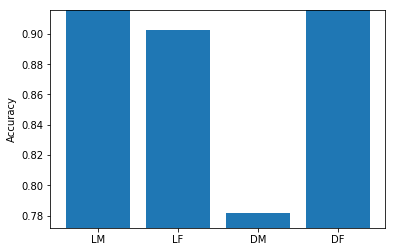

In [38]:
plt.bar(range(4), standard_cnn_accuracy)
plt.xticks(range(4), ("LM","LF", "DM", "DF"))
plt.ylim(np.min(standard_cnn_accuracy)-0.01, np.max(standard_cnn_accuracy[-1]))
plt.ylabel("Accuracy")

In [0]:
# Function to calculate VAE loss given an input x, reconstructed output x_pred, 
#    encoded means mu, encoded log of standard deviation logsigma, and weight parameter for the latent loss
def vae_loss_function(x, x_pred, mu, logsigma, kl_weight=0.0005):
  '''TODO: Define the latent loss'''
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1) # TODO
  '''TODO: Define the reconstruction loss. Hint: you'll need to use tf.reduce_mean'''
  reconstruction_loss = tf.reduce_mean((x-x_pred)**2, axis=(1,2,3)) # TODO
  '''TODO: Define the VAE loss'''
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

In [0]:

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    args (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(args):
    z_mean, z_logsigma = args
    batch = z_mean.shape[0]
    dim = z_mean.shape[1]
    
    # by default, random_normal has mean=0 and std=1.0
    epsilon = tf.random_normal(shape=(batch, dim))
    '''TODO: Define the reparameterization computation!'''
    return z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon # TODO

In [0]:
# Loss function for DB-VAE
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  '''TODO: call the relevant function to obtain VAE loss'''
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma) # TODO
  '''TODO: define the classification loss'''
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit) # TODO
  
  # Use the training data labels to create variable face_mask
  face_mask = tf.cast(tf.equal(y, 1), tf.float32)
  
  '''TODO: define the DB-VAE total loss! Hint: think about the dimensionality of your output.'''
  total_loss = tf.reduce_mean(
      classification_loss + 
      face_mask * vae_loss
  )
  
  return total_loss, classification_loss

In [0]:
# DB-VAE architecture
latent_dim = 100

In [0]:
'''Define the encoder network for the DB-VAE'''
def make_face_encoder_network():
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

    inputs = tf.keras.layers.Input(shape=(64,64,3))
    
    hidden = Conv2D(filters=1*n_filters, kernel_size=[5,5],  strides=[2,2])(inputs)
    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(filters=2*n_filters, kernel_size=[5,5],  strides=[2,2])(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(filters=4*n_filters, kernel_size=[3,3],  strides=[2,2])(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(filters=6*n_filters, kernel_size=[3,3],  strides=[1,1])(hidden)
    hidden = BatchNormalization()(hidden)

    hidden = Flatten(name='flatten')(hidden)
#     hidden = Dense(128)(hidden)
    
    '''Encoder outputs:
        y_logit: supervised class prediction
        z_mean: means in the latent space
        z_logsigma: standard deviations in the latent space'''
    y_logit = Dense(1, activation=None, name='y_logit')(hidden)
    z_mean = Dense(latent_dim, name='z_mean')(hidden)
    z_logsigma = Dense(latent_dim, name='z_logsigma')(hidden)

    # use reparameterization trick to sample from the latent space
    z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_logsigma])

    # define the outputs that the encoder model should return
    outputs = [y_logit, z_mean, z_logsigma, z]
    # finalize the encoder model
    encoder = tf.keras.Model(inputs=inputs, outputs=outputs, name='encoder')

    # get the shape of the final convolutional output (right before the flatten)
    flatten_layer_idx = encoder.layers.index(encoder.get_layer('flatten'))
    pre_flatten_shape = encoder.layers[flatten_layer_idx-1].get_output_at(0).shape[1:]
    
    return encoder, inputs, outputs, pre_flatten_shape

In [0]:
'''Define the decoder network for the DB-VAE'''
def make_face_decoder_network(pre_flatten_shape):
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
  
#   hidden = Dense(128)(latent_inputs)
  hidden = Dense(tf.reduce_prod(pre_flatten_shape))(latent_inputs)
  hidden = tf.keras.layers.Reshape(pre_flatten_shape)(hidden)
  
  # series of deconvolutional layers with batch normalization
  hidden = Conv2DTranspose(filters=4*n_filters, kernel_size=[3,3],  strides=[1,1])(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Conv2DTranspose(filters=2*n_filters, kernel_size=[3,3],  strides=[2,2])(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Conv2DTranspose(filters=1*n_filters, kernel_size=[5,5],  strides=[2,2])(hidden)
  hidden = BatchNormalization()(hidden)
  
  x_hat = Conv2DTranspose(filters=3, kernel_size=[5,5], strides=[2,2])(hidden)

  # instantiate decoder model
  decoder = tf.keras.Model(inputs=latent_inputs, outputs=x_hat, name='decoder')
  return decoder

In [69]:
'''TODO: create the encoder and decoder networks'''
encoder, inputs, ouputs, pre_flatten_shape = make_face_encoder_network() # TODO
decoder = make_face_decoder_network(pre_flatten_shape) # TODO

# initialize the models
encoder_output = encoder(inputs)
y_logit, z_mean, z_logsigma, z = encoder_output
reconstructed_inputs = decoder(z)

TypeError: ignored